# Outbrain Clicks

The dataset for this challenge contains a sample of users’ page views and clicks, as observed on multiple publisher sites in the United States between 14-June-2016 and 28-June-2016. Each viewed page or clicked recommendation is further accompanied by some semantic attributes of those documents. 

The dataset contains numerous sets of content recommendations served to a specific user in a specific context. Each context (i.e. a set of recommendations) is given a display_id. In each such set, the user has clicked on at least one recommendation. The identities of the clicked recommendations in the test set are not revealed. Your task is to rank the recommendations in each group by decreasing predicted likelihood of being clicked.

Each user in the dataset is represented by a unique id (uuid). A person can view a document (document_id), which is simply a web page with content (e.g.  a news article). On each document, a set of ads (ad_id) are displayed. Each ad belongs to a campaign (campaign_id) run by an advertiser (advertiser_id). You are also provided metadata about the document, such as which entities are mentioned, a taxonomy of categories, the topics mentioned, and the publisher.

For this case, we will doing exploratory data analysis, data merging and machine learning from 5 datasets: page_views.csv, events.csv, click_train.csv, promoted_contents.csv and documents_meta.csv.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

## Page Views

As a warning, this is a very large relational dataset. While most of the tables are small enough to fit in memory, the page views log (page_views.csv) is over 2 billion rows and 100GB uncompressed. Because of computation limit, I decide to cut down the rows into first 1,000,000 rows.

In [2]:
page_views = pd.read_csv('page_views_sample.csv', nrows=1000000)

In [3]:
page_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   uuid            1000000 non-null  object
 1   document_id     1000000 non-null  int64 
 2   timestamp       1000000 non-null  int64 
 3   platform        1000000 non-null  int64 
 4   geo_location    999992 non-null   object
 5   traffic_source  1000000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 45.8+ MB


In [4]:
page_views.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2


page_views.csv is a the log of users visiting documents. To save disk space, the timestamps in the entire dataset are relative to the first time in the dataset. If you wish to recover the actual epoch time of the visit, add 1465876799998 to the timestamp.

uuid
document_id
timestamp (ms since 1970-01-01 - 1465876799998)
platform (desktop = 1, mobile = 2, tablet =3)
geo_location (country>state>DMA)
traffic_source (internal = 1, search = 2, social = 3)

### Timestamp
In this section, we will change timestamp into date format

In [5]:
timestamp = (page_views['timestamp']+1465876799998)//1000
page_views['date'] = pd.to_datetime(timestamp, unit='s')

In [6]:
page_views['date'].describe()

count                 1000000
unique                  86345
top       2016-06-14 14:08:10
freq                       49
first     2016-06-14 04:00:00
last      2016-06-15 03:59:59
Name: date, dtype: object

Well, our downsampled data is ranged from 2016-06-14 04:00:00 until 2016-06-15 03:59:59. Let's create column in page_views that shows the exact date and time.

### Page Views By User

Let's count how many page views per user

In [7]:
page_views_by_user = page_views.groupby('uuid').count().iloc[:,0].sort_values(ascending = False).reset_index().rename(columns = {'uuid':'uuid', 'document_id':'count'})
page_views_by_user.describe()

,count
count,985617.000000
mean,1.014593
std,0.120953
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000


In [8]:
page_views_by_user.head()

,uuid,count
0,c1cbfb456fb2c4,4
1,10e29aa12ef22d,4
2,351e984baca257,4
3,f9c8b17fc804e2,3
4,f43d559f2e42ee,3


At the time range, the maximum click number fom a single user is 4. However how many are them?

In [9]:
page_views_by_user_count = page_views_by_user.groupby('count').count().reset_index().rename(columns = {'uuid':'usersCount', 'count':'pageViewsByUser'})

In [10]:
page_views_by_user_count

,pageViewsByUser,usersCount
0,1,971354
1,2,14146
2,3,114
3,4,3


Table above show that 971,354 users have only 1 page view in the dataset, while only 3 users click 4 page views.

In [11]:
page_views_count = page_views.timestamp.count()
page_views_count

1000000

In [12]:
distinct_user = page_views_by_user['count'].count()
distinct_user

985617

In [13]:
ave_page_views_per_user = page_views_count / distinct_user
ave_page_views_per_user

1.0145928895301115

On average, an user only open a single page during the period.

In [14]:
page_views_by_user_count['cumulative_percentage'] = page_views_by_user_count['usersCount'].cumsum()*100/distinct_user

In [15]:
page_views_by_user_count

,pageViewsByUser,usersCount,cumulative_percentage
0,1,971354,98.552886
1,2,14146,99.988129
2,3,114,99.999696
3,4,3,100.000000


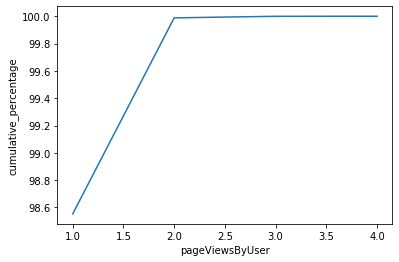

In [16]:
sns.lineplot(y='cumulative_percentage', x='pageViewsByUser',data=page_views_by_user_count)

In the cumululative percentage chart above, 99.5% have only 1 page view, and 99.99% have at most 2 page views.

### Pages View By Platform
As we mentioned above, platform column means platform that the users use;
desktop = 1, mobile = 2, tablet =3

In [17]:
platform = page_views.groupby('platform')['document_id'].count().reset_index().rename(columns = {'document_id':'count'}).sort_values('count', ascending = False)

In [18]:
platform['platform'] = platform['platform'].map({1:'desktop',2:'mobile',3:'tablet'})
platform['percentage'] = platform['count']*100/platform['count'].sum()

platform

,platform,count,percentage
1,mobile,450526,45.0526
0,desktop,446894,44.6894
2,tablet,102580,10.2580


Text(0, 0.5, '')

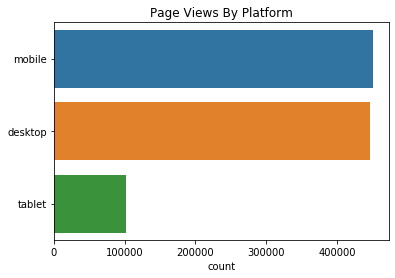

In [19]:
sns.barplot(y=platform['platform'], x=platform['count'], orient = 'h', order = platform['platform'])
plt.title('Page Views By Platform')
plt.ylabel('')

As we could see, mobile and desktop dominated. There are only less than 50,000 views or roughly 9% that used tablet.

### Page Views By Traffic Source
traffic_source (internal = 1, search = 2, social = 3)

In [20]:
traffic = page_views.groupby('traffic_source')['document_id'].count().reset_index().rename(columns = {'document_id':'count'}).sort_values('count', ascending = False)

In [21]:
traffic['traffic_source'] = traffic['traffic_source'].map({1:'internal',2:'search',3:'social'})
traffic['percentage'] = traffic['count']*100/traffic['count'].sum()
traffic

,traffic_source,count,percentage
0,internal,630924,63.0924
2,social,202625,20.2625
1,search,166451,16.6451


Text(0, 0.5, '')

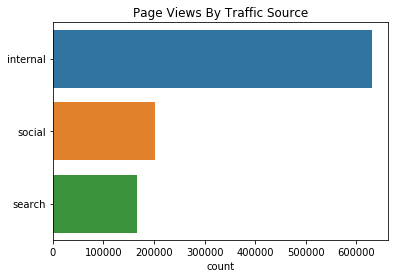

In [22]:
sns.barplot(y=traffic['traffic_source'], x=traffic['count'], orient = 'h', order = traffic['traffic_source'])
plt.title('Page Views By Traffic Source')
plt.ylabel('')

Traffic source from internal is dominating here.

### Most Visited Document
Let's find out which document is the most often to be clicked!

In [23]:
page_views.groupby(['document_id']).count()['platform'].reset_index().rename(columns = {'platform':'count'}).sort_values('count', ascending = False).head(10)

,document_id,count
108,42744,156231
4785,1790442,91420
2074,732651,74630
57,25792,72078
4676,1770064,63370
1459,468335,57584
4301,1669669,16858
4060,1586626,10813
601,199999,10309
1269,399196,10266


## Events
In this section, we would try to read events.csv and perform join with page_views.csv. Because of computation limit, we would only read 1,000,000 rows from the file.

In [25]:
events = pd.read_csv('events.csv', nrows=1000000)

In [26]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   display_id    1000000 non-null  int64 
 1   uuid          1000000 non-null  object
 2   document_id   1000000 non-null  int64 
 3   timestamp     1000000 non-null  int64 
 4   platform      1000000 non-null  object
 5   geo_location  999976 non-null   object
dtypes: int64(3), object(3)
memory usage: 45.8+ MB


In [26]:
events.groupby('document_id').count()['display_id'].reset_index().sort_values('display_id', ascending=False)

,document_id,display_id
56746,1179111,15659
85156,1690149,13281
21920,394689,11818
88957,1717049,8517
102008,1772854,5928
...,...,...
49773,1029462,1
49772,1029461,1
49771,1029458,1
49769,1029450,1


In [28]:
uuid_count = events.uuid.value_counts()

Text(0, 0.5, 'Count')

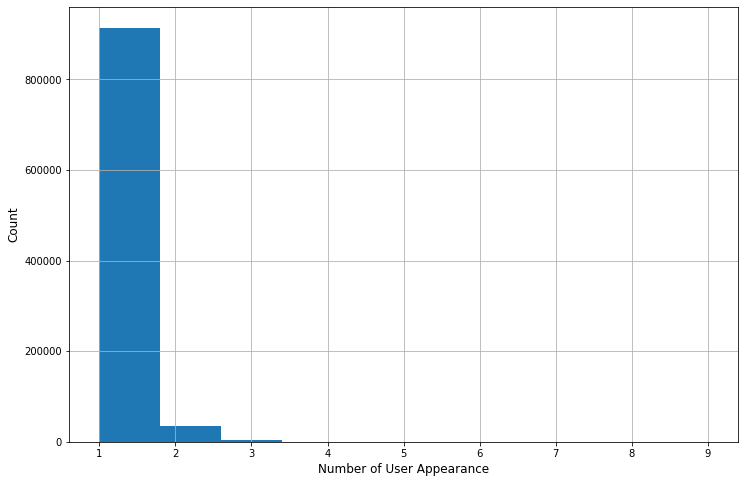

In [34]:
plt.figure(figsize=(12, 8))
uuid_count.hist()
plt.xlabel('Number of User Appearance', fontsize=12)
plt.ylabel('Count', fontsize=12)

In events data, most of user only appeared once.

### Average Events By Distinct User

In [28]:
events_count = events.count()['uuid']

events_count

1000000

In [29]:
distinct_user = events.uuid.nunique()
distinct_user

954298

In [30]:
average_events_by_user = events_count/distinct_user
average_events_by_user

1.047890700808343

In [31]:
timestamp = (events['timestamp']+1465876799998)//1000
events['date'] = pd.to_datetime(timestamp, unit='s')

In [32]:
events['date'].describe()

count                 1000000
unique                  61441
top       2016-06-14 17:33:32
freq                       43
first     2016-06-14 04:00:00
last      2016-06-14 21:04:03
Name: date, dtype: object

In our events dataset, the date range from 2016-06-14 04:00:00 to 2016-06-14 21:04:03.

### Data Merging Between page_views and events

We begin by joining identical columns such as uuid, document_id, geo_location, platform, and timestamp

In [33]:
join = pd.merge(page_views,events, how='inner', on=['uuid', 'document_id','geo_location','platform','timestamp'])
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4091 entries, 0 to 4090
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   uuid            4091 non-null   object        
 1   document_id     4091 non-null   int64         
 2   timestamp       4091 non-null   int64         
 3   platform        4091 non-null   object        
 4   geo_location    4091 non-null   object        
 5   traffic_source  4091 non-null   int64         
 6   date_x          4091 non-null   datetime64[ns]
 7   display_id      4091 non-null   int64         
 8   date_y          4091 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 319.6+ KB


There are only 4091 columns, now let's try neglecting timestamp

In [34]:
join = pd.merge(page_views,events, how='inner', on=['uuid', 'document_id','geo_location','platform'])
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5705 entries, 0 to 5704
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   uuid            5705 non-null   object        
 1   document_id     5705 non-null   int64         
 2   timestamp_x     5705 non-null   int64         
 3   platform        5705 non-null   object        
 4   geo_location    5705 non-null   object        
 5   traffic_source  5705 non-null   int64         
 6   date_x          5705 non-null   datetime64[ns]
 7   display_id      5705 non-null   int64         
 8   timestamp_y     5705 non-null   int64         
 9   date_y          5705 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 490.3+ KB


There are approximately additional 1700 rows! But why is that?

In [35]:
join.head()

,uuid,document_id,timestamp_x,platform,geo_location,traffic_source,date_x,display_id,timestamp_y,date_y
0,21f59fa7234408,7091,35133583,1,US>NY>555,2,2016-06-14 13:45:33,427040,35134211,2016-06-14 13:45:34
1,feef9c582ab4e4,7702,35828433,1,GB>I6,1,2016-06-14 13:57:08,441605,35828717,2016-06-14 13:57:08
2,71f15566299263,10172,18227103,1,PH>D9,1,2016-06-14 09:03:47,173127,18256813,2016-06-14 09:04:16
3,bbdd0ab5f058db,10172,24853365,1,IN>19,1,2016-06-14 10:54:13,244705,25169423,2016-06-14 10:59:29
4,a81c3603da5e00,10653,25778685,1,US>MI>563,2,2016-06-14 11:09:38,253172,25779367,2016-06-14 11:09:39


if we look in the table above, there is delta seconds between timestamp in page_views and events. Let's calculate the delta between those timestamp!

In [36]:
join['delta timestamp'] = join['timestamp_y'] - join['timestamp_x']

In [37]:
join['delta timestamp'].describe()

count    5.705000e+03
mean     9.932745e+05
std      4.587346e+06
min     -7.403717e+06
25%      0.000000e+00
50%      0.000000e+00
75%      3.180000e+02
max      5.258621e+07
Name: delta timestamp, dtype: float64

On average, there is 993,274 seconds of gap, however it may be biased because of large outliers. We can see that at least 50% or median of matching rows is identical or 0 seconds of gap, however at 75 % there are gap of 318 seconds.
These differences might be caused by when the page view is logged on page load for some platform, then after some time in the browser, the user click in an ad and display_id is logged with difference timestamp.

As we have the differences between page views and events timestamps, we decided to use hour from both datasets to perform merging.

In [38]:
events['hour'] = events['date'].dt.hour
page_views['hour'] = page_views['date'].dt.hour

In [39]:
join = pd.merge(page_views,events, how='inner', on=['uuid', 'document_id','geo_location','platform','hour'])
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5316 entries, 0 to 5315
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   uuid            5316 non-null   object        
 1   document_id     5316 non-null   int64         
 2   timestamp_x     5316 non-null   int64         
 3   platform        5316 non-null   object        
 4   geo_location    5316 non-null   object        
 5   traffic_source  5316 non-null   int64         
 6   date_x          5316 non-null   datetime64[ns]
 7   hour            5316 non-null   int64         
 8   display_id      5316 non-null   int64         
 9   timestamp_y     5316 non-null   int64         
 10  date_y          5316 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(6), object(3)
memory usage: 498.4+ KB


In [40]:
join['hour'].describe()

count    5316.000000
mean       12.808691
std         5.070944
min         4.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        21.000000
Name: hour, dtype: float64

The minimum and maximum hour are exactly the same with our events.csv data! 

In [63]:
join.sort_values('display_id')

,uuid,document_id,timestamp_x,platform,geo_location,traffic_source,date_x,hour,display_id,timestamp_y,date_y
3761,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1,2016-06-14 04:00:02,4,37,2687,2016-06-14 04:00:02
3798,46f17380f19cee,1779285,24079,2,US>NY>501,1,2016-06-14 04:00:24,4,335,24079,2016-06-14 04:00:24
3890,ea1098aff6e0ee,1790442,42591,2,US,1,2016-06-14 04:00:42,4,568,42591,2016-06-14 04:00:42
3418,d7b9d503498029,1748589,43935,2,AU>07,3,2016-06-14 04:00:43,4,591,43935,2016-06-14 04:00:43
4926,a474db888e8b61,1790442,47506,2,US>AZ>789,1,2016-06-14 04:00:47,4,655,47506,2016-06-14 04:00:47
...,...,...,...,...,...,...,...,...,...,...,...
3363,f06017e6b207bd,1738055,61396264,1,US>CA>803,3,2016-06-14 21:03:16,21,999015,61396264,2016-06-14 21:03:16
3410,f49a658090359d,1747427,61422564,3,US>TX>633,1,2016-06-14 21:03:42,21,999558,61422564,2016-06-14 21:03:42
1302,bff9d8943fce31,468335,61432533,1,US>WI>669,3,2016-06-14 21:03:52,21,999748,61432533,2016-06-14 21:03:52
4884,2f09601d9d1b16,1790442,61436455,1,US>WA>819,1,2016-06-14 21:03:56,21,999832,61436455,2016-06-14 21:03:56


## Train 

Now, let's import the train datasets! There ad_id, display_id and most important clicked variables that explained whetter the user clicked the ads or not.

In [41]:
train = pd.read_csv('clicks_train.csv')

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87141731 entries, 0 to 87141730
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   display_id  int64
 1   ad_id       int64
 2   clicked     int64
dtypes: int64(3)
memory usage: 1.9 GB


In [43]:
train.groupby('ad_id').count()['display_id']

ad_id
1           2
2          22
3         161
4          32
5           1
         ... 
547866      4
547875      1
547879      3
547924      2
548019      1
Name: display_id, Length: 478950, dtype: int64

## Promoted Contents

promoted_content.csv provides details on the ads such as:

ad_id
document_id
campaign_id
advertiser_id

In [44]:
pc = pd.read_csv('promoted_content.csv')

In [45]:
pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559583 entries, 0 to 559582
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   ad_id          559583 non-null  int64
 1   document_id    559583 non-null  int64
 2   campaign_id    559583 non-null  int64
 3   advertiser_id  559583 non-null  int64
dtypes: int64(4)
memory usage: 17.1 MB


In [46]:
pc.groupby('ad_id').count()['document_id'].reset_index().sort_values('document_id', ascending= False)

,ad_id,document_id
0,1,1
373058,375472,1
373052,375466,1
373053,375467,1
373054,375468,1
...,...,...
186522,187639,1
186521,187638,1
186520,187637,1
186519,187636,1


We could see that each ad_id has unique document_id. Now, let's merging it with train datasets!

In [47]:
join_pc_train = pd.merge(pc, train, how='inner', on=['ad_id'])
join_pc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87141731 entries, 0 to 87141730
Data columns (total 6 columns):
 #   Column         Dtype
---  ------         -----
 0   ad_id          int64
 1   document_id    int64
 2   campaign_id    int64
 3   advertiser_id  int64
 4   display_id     int64
 5   clicked        int64
dtypes: int64(6)
memory usage: 4.5 GB


In [48]:
join_pc_train.sort_values('display_id').head(10)

,ad_id,document_id,campaign_id,advertiser_id,display_id,clicked
34725977,144739,1337362,18488,2909,1,1
8420042,42337,938164,5969,1499,1,0
40202332,156824,992370,7283,1919,1,0
32542400,139684,1085937,17527,2563,1,0
68629295,279295,1670176,27524,1820,1,0
72119434,296965,1133290,28334,3922,1,0
43761690,169564,1394819,20109,640,2,0
27420282,125211,876083,16054,772,2,0
73230097,308455,1712989,245,232,2,1
40127770,156535,630534,16636,380,2,0


## Documents Meta

documents_meta.csv provides details on the documents.

document_id
source_id (the part of the site on which the document is displayed, e.g. edition.cnn.com)
publisher_id
publish_time

In [50]:
dm = pd.read_csv('documents_meta.csv')
dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999334 entries, 0 to 2999333
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   document_id   int64  
 1   source_id     float64
 2   publisher_id  float64
 3   publish_time  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 91.5+ MB


Now, we join the documents_meta.csv with our previous merging datasets!

In [51]:
join_pc_train_dm = pd.merge(join_pc_train, dm, how='inner', on=['document_id'])
join_pc_train_dm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87141731 entries, 0 to 87141730
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ad_id          int64  
 1   document_id    int64  
 2   campaign_id    int64  
 3   advertiser_id  int64  
 4   display_id     int64  
 5   clicked        int64  
 6   source_id      float64
 7   publisher_id   float64
 8   publish_time   object 
dtypes: float64(2), int64(6), object(1)
memory usage: 6.5+ GB


## Final Join

Let's perform our last data merging!

In [54]:
join_final = pd.merge(join_pc_train_dm, join, how='inner', on=['display_id'])
join_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29220 entries, 0 to 29219
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ad_id           29220 non-null  int64         
 1   document_id_x   29220 non-null  int64         
 2   campaign_id     29220 non-null  int64         
 3   advertiser_id   29220 non-null  int64         
 4   display_id      29220 non-null  int64         
 5   clicked         29220 non-null  int64         
 6   source_id       29217 non-null  float64       
 7   publisher_id    8682 non-null   float64       
 8   publish_time    23013 non-null  object        
 9   uuid            29220 non-null  object        
 10  document_id_y   29220 non-null  int64         
 11  timestamp_x     29220 non-null  int64         
 12  platform        29220 non-null  object        
 13  geo_location    29220 non-null  object        
 14  traffic_source  29220 non-null  int64         
 15  da

The rows are nearly 6 times bigger than our original join data. Why is that?

In [83]:
join_final['display_id'].duplicated().sum()

23904

It turns out there are 23904 duplicates in our display_id variable! Is that normal?

In [87]:
join_final.groupby('display_id').count()['ad_id'].reset_index().sort_values('ad_id', ascending = False).head(10)

,display_id,ad_id
4605,846164,12
4119,734838,10
2335,438119,10
4544,832120,10
3069,545073,10
5031,936011,10
1410,184103,10
3094,547393,10
4003,711894,10
3099,548191,10


That duplication can be explained if we try to explore more about the work flow. Whenever users visiting a website or a document_id, they will be provided by sets of content recommendations served to a specific user in a specific context that recorded as display_id. Within display_id, there are a few ads thats each described by ad_id. Then, there is click field, which shows that certain ad_id that clicked within a display_id. Now we must ensure that each display_id is only having one clicked. 

In [88]:
join_final.groupby('display_id').sum()['clicked'].reset_index().sort_values('clicked',ascending=False).describe()['clicked']

count    5316.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: clicked, dtype: float64

The table above shows that our display_id has already been in a correct shape. Now how about the hour range? Is it still the same like our original join table?

In [79]:
join_final['hour'].describe()

count    29220.000000
mean        12.857084
std          5.089484
min          4.000000
25%          9.000000
50%         14.000000
75%         17.000000
max         21.000000
Name: hour, dtype: float64

Well the hour range is identical like our original join data! Now, let's take a look at the data!

In [56]:
join_final.head(10)

,ad_id,document_id_x,campaign_id,advertiser_id,display_id,clicked,source_id,publisher_id,publish_time,uuid,document_id_y,timestamp_x,platform,geo_location,traffic_source,date_x,hour,timestamp_y,date_y
0,3,7692,3,7,943864,0,1147.0,62.0,2010-06-21 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
1,7,12808,1,7,943864,0,1483.0,182.0,2010-12-31 09:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
2,88954,1065906,11523,407,943864,0,5320.0,636.0,2015-12-30 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
3,123702,1218354,15884,2066,943864,0,8874.0,NaN,NaN,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
4,132478,1292703,17001,3082,943864,0,11847.0,595.0,2016-04-12 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
5,165380,1378725,20586,2007,943864,0,12293.0,NaN,2015-12-08 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
6,212230,1522925,8344,472,943864,1,2845.0,NaN,2016-05-26 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
7,250081,1618502,26182,2151,943864,0,9698.0,NaN,2016-06-05 00:00:00,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34
8,3,7692,3,7,947689,0,1147.0,62.0,2010-06-21 00:00:00,9a47fd405b212c,1669669,58922525,2,US>TX>618,1,2016-06-14 20:22:02,20,59062086,2016-06-14 20:24:22
9,7,12808,1,7,947689,0,1483.0,182.0,2010-12-31 09:00:00,9a47fd405b212c,1669669,58922525,2,US>TX>618,1,2016-06-14 20:22:02,20,59062086,2016-06-14 20:24:22


There are anomalies here because the document_id is not matched! Our interpretation is that the document_id from events.csv and promoted_content.csv might be from two different classes. The one from events.csv (document_id_y) is the document which a display of ads being displayed, while the one from promoted_content.csv (document_id_x) is the document which the ad links when clicked. So, it explained why the document_id_y is identical within a display_id.

Now, let's handle the missing value!

In [89]:
join_final.isna().sum()

ad_id                 0
document_id_x         0
campaign_id           0
advertiser_id         0
display_id            0
clicked               0
source_id             3
publisher_id      20538
publish_time       6207
uuid                  0
document_id_y         0
timestamp_x           0
platform              0
geo_location          0
traffic_source        0
date_x                0
hour                  0
timestamp_y           0
date_y                0
dtype: int64

There are missing values in publisher_id, publish_time and source_id which all are belong to documents_meta.csv. If we take a look at the definition of documents_meta.csv, that file provides details on the documents such as source_id the part of the site on which the document is displayed, e.g. edition.cnn.com.

Well, we might be wrong by joining it with the document_id that belong to promoted_content.csv. The document_id in documents_meta.csv might refer to document_id in events.csv. So we have to join our join_final data to documents_meta.csv

In [97]:
join_final = join_final.rename(columns={'document_id_y':'document_id'})

In [102]:
join_final = join_final.drop(['source_id', 'publisher_id', 'publish_time'], axis=1)

In [108]:
join_final = pd.merge(join_final, dm, how='inner', on=['document_id'])
join_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29220 entries, 0 to 29219
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ad_id           29220 non-null  int64         
 1   document_id_x   29220 non-null  int64         
 2   campaign_id     29220 non-null  int64         
 3   advertiser_id   29220 non-null  int64         
 4   display_id      29220 non-null  int64         
 5   clicked         29220 non-null  int64         
 6   uuid            29220 non-null  object        
 7   document_id     29220 non-null  int64         
 8   timestamp_x     29220 non-null  int64         
 9   platform        29220 non-null  object        
 10  geo_location    29220 non-null  object        
 11  traffic_source  29220 non-null  int64         
 12  date_x          29220 non-null  datetime64[ns]
 13  hour            29220 non-null  int64         
 14  timestamp_y     29220 non-null  int64         
 15  da

We made it to nultify missing values in source_id and publisher_id! Now let's explore publish_time!

In [162]:
join_final['publish_time'].value_counts().reset_index().head(10)

,index,publish_time
0,2016-06-13 10:00:00,7426
1,2011-08-04 10:00:00,3982
2,2016-03-02 00:00:00,1826
3,2015-06-23 11:00:00,1790
4,2016-06-08 15:00:00,1488
5,2016-06-13 00:00:00,536
6,2016-05-31 00:00:00,435
7,2016-04-12 21:00:00,350
8,2016-06-13 15:00:00,344
9,2016-06-13 11:00:00,311


Interestingly, the most counted publish time is 2016-06-13 10:00:00 and 2011-08-04 10:00:00 for approximately 10,000 times.

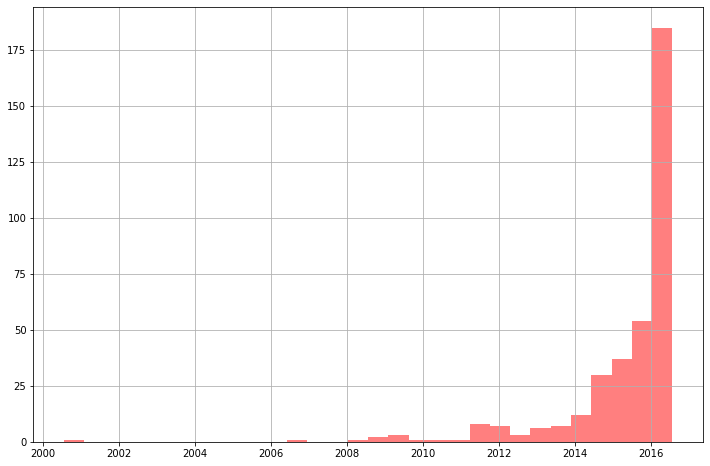

In [160]:
fig, ax = plt.subplots(figsize = [12,8])
plt.style.use('ggplot')
join_final['publish_time'].value_counts().reset_index()['index'].hist(alpha = 0.5,bins=30 ,color='red')

If we look at the graph above, the document mostly published on 2016. 

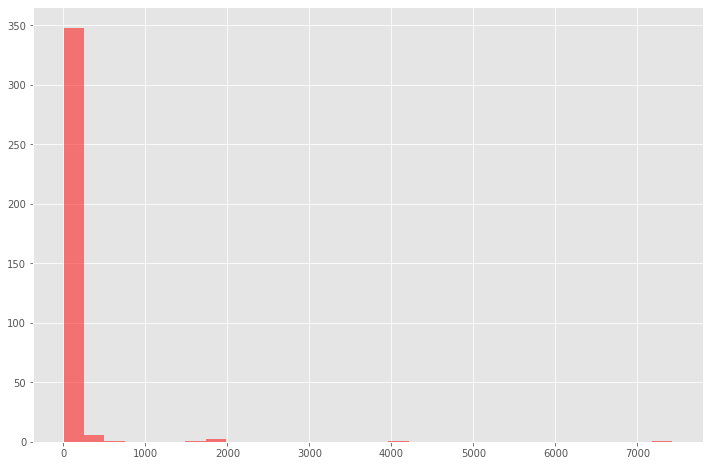

In [161]:
fig, ax = plt.subplots(figsize = [12,8])
plt.style.use('ggplot')
join_final['publish_time'].value_counts().reset_index()['publish_time'].hist(alpha = 0.5,bins=30 ,color='red')

However, not many documents published on the same time. Mostly, published on unique time. Now, let's see the min and max published date:

In [150]:
join_final['publish_time'].astype('datetime64').min()

Timestamp('2000-07-18 00:00:00')

In [151]:
join_final['publish_time'].astype('datetime64').max()

Timestamp('2016-07-26 00:00:00')

Turns out that the maximum publish time of our documents exceed our original range of time! We conclude that there are misinformation in the publish_time column which could cause disruption in our machine learning process. Therefore, we decide to drop the column.

In [49]:
join_final = join_final.drop('publish_time', axis=1)

In [170]:
join_final

,ad_id,document_id_x,campaign_id,advertiser_id,display_id,clicked,uuid,document_id,timestamp_x,platform,geo_location,traffic_source,date_x,hour,timestamp_y,date_y,source_id,publisher_id
0,3,7692,3,7,943864,0,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34,6698.0,784.0
1,7,12808,1,7,943864,0,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34,6698.0,784.0
2,88954,1065906,11523,407,943864,0,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34,6698.0,784.0
3,123702,1218354,15884,2066,943864,0,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34,6698.0,784.0
4,132478,1292703,17001,3082,943864,0,8e433f7339e1ba,1669669,58894964,2,US>CA>803,1,2016-06-14 20:21:34,20,58894964,2016-06-14 20:21:34,6698.0,784.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29215,236019,1511954,1150,1140,654959,1,40c9295e6a9a35,214048,46024670,2,IN>19,2,2016-06-14 16:47:04,16,46024670,2016-06-14 16:47:04,481.0,607.0
29216,238429,1598289,25757,3803,654959,0,40c9295e6a9a35,214048,46024670,2,IN>19,2,2016-06-14 16:47:04,16,46024670,2016-06-14 16:47:04,481.0,607.0
29217,355521,1807252,29590,563,654959,0,40c9295e6a9a35,214048,46024670,2,IN>19,2,2016-06-14 16:47:04,16,46024670,2016-06-14 16:47:04,481.0,607.0
29218,257565,1556282,26491,3190,425715,1,20c15ad838bdc6,337012,34771384,1,US>FL>534,1,2016-06-14 13:39:31,13,35074287,2016-06-14 13:44:34,3012.0,291.0


In [172]:
join_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29220 entries, 0 to 29219
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ad_id           29220 non-null  int64         
 1   document_id_x   29220 non-null  int64         
 2   campaign_id     29220 non-null  int64         
 3   advertiser_id   29220 non-null  int64         
 4   display_id      29220 non-null  int64         
 5   clicked         29220 non-null  int64         
 6   uuid            29220 non-null  object        
 7   document_id     29220 non-null  int64         
 8   timestamp_x     29220 non-null  int64         
 9   platform        29220 non-null  object        
 10  geo_location    29220 non-null  object        
 11  traffic_source  29220 non-null  int64         
 12  date_x          29220 non-null  datetime64[ns]
 13  hour            29220 non-null  int64         
 14  timestamp_y     29220 non-null  int64         
 15  da

Now let's see how many distinct ads in our final join dataset:

In [17]:
ad_count = join_final['ad_id'].value_counts()
ad_count

137111    243
173005    213
24632     198
123742    181
135478    172
         ... 
276017      1
159306      1
261258      1
187980      1
139795      1
Name: ad_id, Length: 7435, dtype: int64

Text(0, 0.5, 'log(Count of displays with ad)')

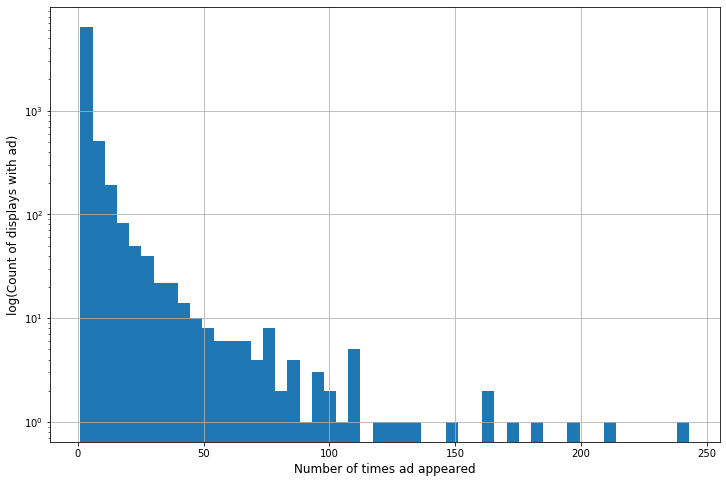

In [19]:
plt.figure(figsize=(12, 8))
ad_count.hist(bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)

In our final dataset, there are big number of ads that only appear few times. More than 50% only have less than 10 appearances. This type of dataset show us that to predict whether someone will clicked on a specific ad, we can't only rely to past behaviour of that ad.

Now, let's see how many distinct user compare to our original events data:

In [21]:
user_count = join_final['uuid'].value_counts()
user_count

ba994ec414bfb1    25
d4b482fd2594b2    24
ab4c3c073c2c27    24
e4f702ea48dfc8    20
f96487c0f0e60b    20
                  ..
26c5709847a1cc     2
20c15ad838bdc6     2
7fb741465df49b     2
1a09feb4df1773     2
b997fa441d2518     2
Name: uuid, Length: 5251, dtype: int64

Text(0, 0.5, 'Count')

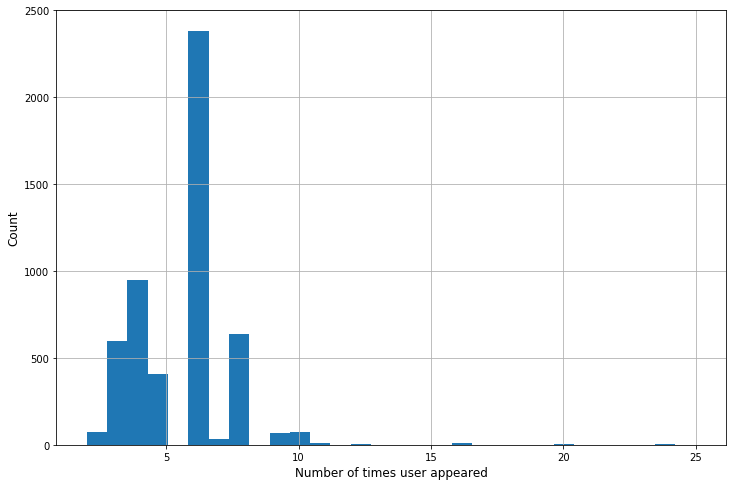

In [39]:
plt.figure(figsize=(12, 8))
user_count.hist(bins=30)
plt.xlabel('Number of times user appeared', fontsize=12)
plt.ylabel('Count', fontsize=12)

Different with events.csv, after merging number of user appearance is vary. It is notable that there are nearly 2500 users that appeared 6 times in our final data. For machine learning, this uuid might be important to predict specific user behaviour. Now let's see our original

In [72]:
platform = join_final.platform.value_counts()
platform

2    13838
1    11717
3     3665
Name: platform, dtype: int64

In [79]:
platform.index = platform.index.map({1:'desktop',2:'mobile',3:'tablet'})

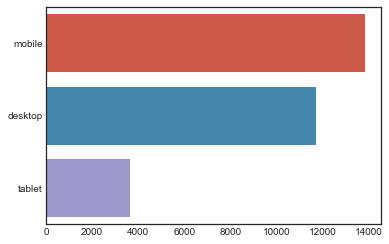

In [91]:
plt.style.use('seaborn-white')
sns.barplot(y=platform.index,x=platform.values, orient='h')

Same with our events dataset, mobile platform is the most used platform. However there is significant gap with desktop platform compare to the events dataset.

In [82]:
traffic = join_final.traffic_source.value_counts()
traffic.index = traffic.index.map({1:'internal',2:'search',3:'social'})

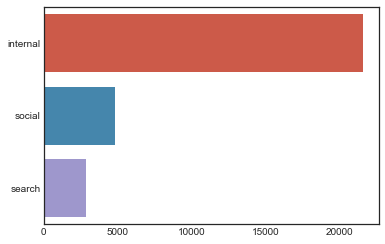

In [92]:
plt.style.use('seaborn-white')
sns.barplot(y=traffic.index,x=traffic.values, orient='h')

Identical with events dataset, internal is the most common traffic source. Let's go ahead to the machine learning!

## Machine Learning

Let's begin by dropping unnecessary columns and changing data types:

In [50]:
join_ml = join_final.drop(['timestamp_y','date_y','date_x'], axis=1)

In [51]:
join_ml['platform'] = join_ml['platform'].astype('category').cat.codes

In [55]:
join_ml['uuid'] = join_ml['uuid'].astype('category').cat.codes

In [52]:
join_ml['geo_location'] = join_ml['geo_location'].astype('category').cat.codes

Then, we begin to separate the data into train and test datasets:

In [43]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(join_ml.drop('clicked',axis=1), join_ml['clicked'], test_size = 0.3)

### Logistic Regression

Let's start with logistic regression:

In [45]:
from sklearn.linear_model import LogisticRegression

In [86]:
log = LogisticRegression()

In [87]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
predictions = log.predict(X_test)

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

In [186]:
print(classification_report(y_test, predictions))

precision    recall  f1-score   support

           0       0.82      1.00      0.90      7207
           1       0.00      0.00      0.00      1559

    accuracy                           0.82      8766
   macro avg       0.41      0.50      0.45      8766
weighted avg       0.68      0.82      0.74      8766



In [188]:
print(confusion_matrix(y_test, predictions))

[[7207    0]
 [1559    0]]


The machine learning perform well if we set 0 or non-clicked as our target. However, logistic regression model won't work at all if we use 1 or clicked ads as our target. Let's try another model:

In [62]:

from sklearn.ensemble import RandomForestClassifier

In [63]:
rfc = RandomForestClassifier(n_estimators=100)

In [64]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
pred = rfc.predict(X_test)


In [66]:
print(classification_report(y_test, pred))

precision    recall  f1-score   support

           0       0.82      0.97      0.89      7128
           1       0.43      0.10      0.16      1638

    accuracy                           0.81      8766
   macro avg       0.63      0.53      0.53      8766
weighted avg       0.75      0.81      0.75      8766



In [193]:
print(classification_report(y_test, pred))

precision    recall  f1-score   support

           0       0.84      0.96      0.89      7207
           1       0.42      0.14      0.21      1559

    accuracy                           0.81      8766
   macro avg       0.63      0.55      0.55      8766
weighted avg       0.76      0.81      0.77      8766



In [194]:
print(confusion_matrix(y_test, pred))

[[6903  304]
 [1340  219]]


Random forest perform slightly better than logistic regression model. However, it is still perform poorly. It can be explained because of there are imbalance class in our targe variable:

In [84]:
join_final.clicked.value_counts()

0    23904
1     5316
Name: clicked, dtype: int64

## Conclusion

To improve the model, there are some tweaks can be done. First, we could increase the information by joining other data. Second, we need to overcome imbalance class problem by doing undersampling or oversampling for our target variables.